In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install catboost

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2655840258842585037
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16059727872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16883134159602179536
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [6]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [12]:
batch_size = 500
testsplit = .5
targetx = 100
targety = 100
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
print(seed)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/raf-db-dataset/DATASET/train/"
data_dir1 = "/kaggle/input/raf-db-dataset/DATASET/test/"

161


In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
       
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


/kaggle/input/raf-db-dataset/DATASET/train/6/train_05298_aligned.jpg


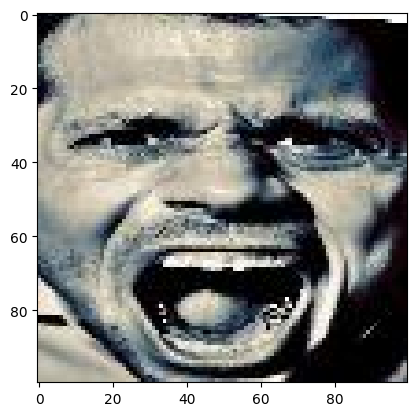

In [14]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [15]:
features_extractor = InceptionV3(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))


In [16]:
def features_numpy_extract(gen):
    gen.reset()
    features_before= None
    label_before = None
    first = True
    for data_batch in gen:
        features = features_extractor(data_batch[0])
        length = features.shape[0]
        features = tf.reshape(features,(length,2048))
        features = features.numpy()

        label = tf.math.argmax(data_batch[1],1)
        label = label.numpy()
        if first:
            features_before= features
            label_before = label
            first = False
            continue 
        
        features_before = np.concatenate((features_before,features),axis=0)
        label_before = np.concatenate((label_before,label),axis=None)
    return features_before,label_before


In [ ]:
feat_train, label_train =features_numpy_extract(train_generator)
feat_test, label_test =features_numpy_extract(test_generator)

In [ ]:
print(feat_train.shape)
print(feat_test.shape)
print(label_train.shape)
print(label_test.shape)

In [ ]:
import numpy as np
import optuna

import catboost as cb
from sklearn.metrics import f1_metric


def objective(trial):
    train_x, valid_x, train_y, valid_y = #

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "6gb",
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'F1',
    }
    pca_param = {
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(cat_features=cat_cols, **param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)

    f1 = f1_score(valid_y, pred_labels)
    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, n_jobs=-1)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))